## Classification with PyTorch

The steps we will go through are as follows:
- Making the notebook device agnostic
- Creating random data for our model
- Data exploration and visualization
- Formatting the data for train and test sets
- Creating our Classification Model
  - Training loop
  - Testing loop
  - Visualizing the loss curve

In [1]:
## first the imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## we will be using sklearn to get data splitting
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
torch.__version__

'2.3.0+cpu'

In [2]:
## making our notebook device agnostic
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## using the make circle for our sample generation
n_samples = 1000
random_seed = 0
X, y = make_circles(n_samples=n_samples,
                    noise=3e-2,
                    random_state=random_seed)
X[:5], y[:5]

(array([[ 0.80993549, -0.053514  ],
        [-0.13448628, -0.74209474],
        [-0.81250606, -0.62424399],
        [ 0.5830736 ,  0.49656776],
        [-0.46132008,  0.65983601]]),
 array([1, 1, 0, 1, 1], dtype=int64))

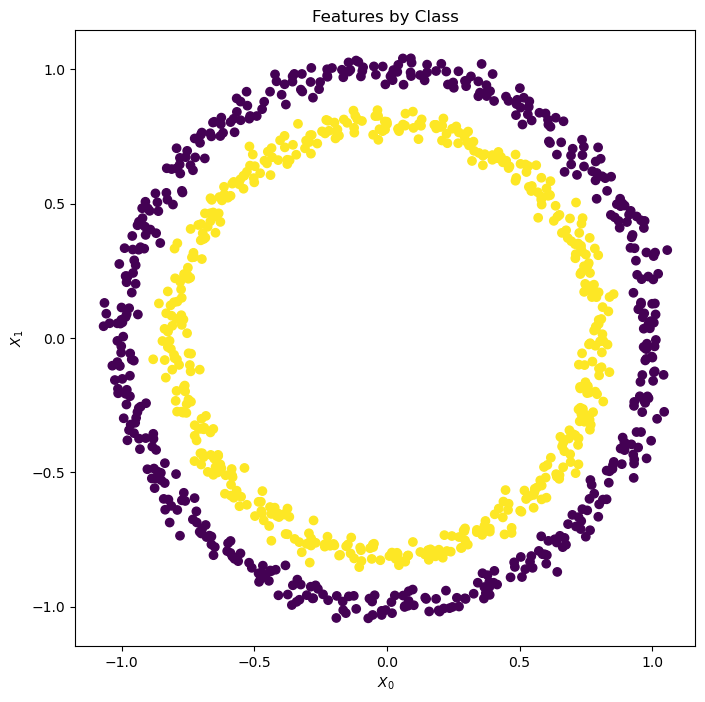

In [4]:
## some data exploration
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:, 1], c=y)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title('Features by Class');

In [5]:
## since our data is already in numerical format
## we don't need to do any real pre-processing
## but we still need to create tensors, adjust dtype, move them to device, and split them
X_tensor = torch.from_numpy(X).type(torch.float32).to(device)
y_tensor = torch.from_numpy(y).type(torch.float32).to(device)
print(X_tensor[:5],'\n', y_tensor[:5])
X_train, X_test = torch.split(X_tensor, [int(.8*X_tensor.shape[0]), int(.2*X_tensor.shape[0])])
y_train, y_test = torch.split(y_tensor, [int(.8*y_tensor.shape[0]), int(.2*y_tensor.shape[0])])
len(X_train), len(y_train), len(X_test), len(y_test)

tensor([[ 0.8099, -0.0535],
        [-0.1345, -0.7421],
        [-0.8125, -0.6242],
        [ 0.5831,  0.4966],
        [-0.4613,  0.6598]]) 
 tensor([1., 1., 0., 1., 1.])


(800, 800, 200, 200)

In [6]:
## next we have to start with our model
class BinaryClassification(nn.Module):
  def __init__(self, in_feature, hidden_layer, out_shape):
    super(BinaryClassification, self).__init__()
    self.l1 = nn.Linear(in_features=in_feature,
                        out_features=hidden_layer)
    self.l2 = nn.Linear(in_features=hidden_layer,
                        out_features=out_shape)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return self.sig(out).squeeze()
hidden_layer = int(8 * X_train.shape[1])
## creating an instance
model = BinaryClassification(in_feature=X_train.shape[1],
                             hidden_layer =hidden_layer,
                             out_shape = 1)
model = model.to(device)
## starting with the loss function
## which will be BC
loss = nn.BCELoss()
## and for our optimizer
## we'll be using Adam
learning_rate = 1e-2
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = learning_rate)
## dict for storing the loss
info_dict = {}
## starting with the training loop
epochs = 500
for e in range(epochs):
  model.train()
  yhat = model(X_train)
  ## calculating the loss
  l = loss(yhat, y_train)
  ## zeroing the grad
  optimizer.zero_grad()
  ## then backward
  l.backward()
  ## taking a step
  optimizer.step()
  if e%10==0:
    info_dict[e] = l.item()
    model.eval()
    with torch.inference_mode():
      ypred = model(X_test)
      l_t = loss(ypred,y_test)
      if e%50==0:
        print(f'Epoch {e} \ntrain loss is: {round(l.item(), 2)}')
        print(f'test loss:{round(l_t.item(), 2)}\n')


Epoch 0 
train loss is: 0.7
test loss:0.7

Epoch 50 
train loss is: 0.62
test loss:0.62

Epoch 100 
train loss is: 0.43
test loss:0.44

Epoch 150 
train loss is: 0.23
test loss:0.24

Epoch 200 
train loss is: 0.12
test loss:0.13

Epoch 250 
train loss is: 0.07
test loss:0.08

Epoch 300 
train loss is: 0.05
test loss:0.06

Epoch 350 
train loss is: 0.04
test loss:0.04

Epoch 400 
train loss is: 0.03
test loss:0.03

Epoch 450 
train loss is: 0.02
test loss:0.03



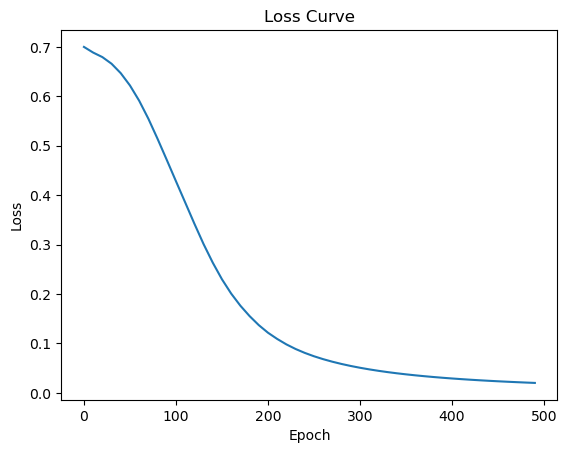

In [7]:
plt.plot(*zip(*info_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss');

The second model

In [8]:
## we will be using some data from UCI for as our sample
## which is for spam/not spam classification
data = pd.read_csv('https://archive.ics.uci.edu/static/public/94/data.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [9]:
## Binary classification with nn.sequantial
class BinaryClassificationSeq(nn.Module):
  def __init__(self, in_features, hidden_layer, out_features):
    super().__init__()
    self.seq = nn.Sequential(

            nn.Linear(in_features=in_features,
                      out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
            out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
            out_features=out_features),
            nn.Sigmoid()
    )

  def forward(self, x):
    return self.seq(x)
